In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,SqrtStretch,LogStretch

from sunpy.net import Fido, attrs
from sunpy.time import TimeRange
from sunpy.map import Map
import sunpy.io.fits
from sunpy.physics.differential_rotation import differential_rotate

import aiapy.calibrate
import aiapy.response

%matplotlib inline

# Analyzing AIA Data with sunpy and aiapy
## LMSAL Python Club — 10 October 2019

All materials related to this tutorial are available at [github.com/wtbarnes/lmsal-sunpy-tutorial](https://github.com/wtbarnes/lmsal-sunpy-tutorial). There are several helpful references listed [here](https://github.com/wtbarnes/lmsal-sunpy-tutorial/blob/master/README.md#resources).

In this tutorial, we'll cover the basic capabilities in `sunpy` for downloading, reading, and manipulating 2D image data. We'll then use the `aiapy` package to do some AIA-specific operations on these images.

## Querying Data

First, let's grab a few AIA images. The main interface for downloading data in `sunpy` is called `Fido`. Using `Fido`, one can query a wide range of data sources (e.g. JSOC, VSO, FTP sites) given many different criteria such as time, instrument, and wavelength.

In this example, we'll query the VSO for AIA 171 images for the twelve hour interval starting on 2010 September 29 23:51:36 at a cadence of 4 hours.


In [2]:
q = Fido.search(
    attrs.Time(TimeRange(astropy.time.Time('2010-09-29T23:51:36'), 12*u.h)),
    attrs.Instrument('AIA'),
    attrs.Sample(4*u.h),
    attrs.Wavelength(171*u.angstrom),
)

In [3]:
q

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2010-09-29 23:51:36,2010-09-29 23:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0
2010-09-30 11:51:36,2010-09-30 11:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0
2010-09-30 03:51:36,2010-09-30 03:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0
2010-09-30 07:51:36,2010-09-30 07:51:37,SDO,AIA,FULLDISK,171.0 .. 171.0


This gives us back a table of four results. To download these, we can pass this results table to `Fido.fetch`.

In [4]:
files = Fido.fetch(q)

Files Downloaded: 100%|██████████| 4/4 [00:02<00:00,  1.83file/s]


Once the download finishes, this returns a list of paths to the locations of the files on your local machine.

**NOTE:** If you're on a machine where the "SUMS" directories can be resolved locally (e.g. LMSAL, Stanford), see [this notebook](advanced/querying-drms.ipynb).

In [5]:
# If the download is slow/not working, just grab them locally
#files = glob.glob('data/aia_lev1_171a_2010_09*.fits')

In [6]:
files = sorted(files)

In [7]:
files

['/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_29t23_51_36_34z_image_lev1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_30t03_51_36_34z_image_lev1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_30t07_51_36_34z_image_lev1.fits',
 '/Users/willbarnes/sunpy/data/aia_lev1_171a_2010_09_30t11_51_36_34z_image_lev1.fits']

## The `Map` Object

The `Map` object is one of two primary data containers in `sunpy` (the other is [`TimeSeries`]() though we will not cover that in this notebook). In this section, we'll walk through how to load data into a `Map` and the various properties that the `Map` object exposes.

### Constructing a `Map`

To read in data from an AIA FITS file, we can simply pass the name of the file to the `Map` object.

In [8]:
m = Map(files[0])

The `Map` object looks at header and recognizes it as an AIA observation.

In [9]:
m

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2010-09-29 23:51:36
Exposure Time:		 2.000175 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599489 0.599489] arcsec / pix
Reference Pixel:	 [2051.120117 2048.379883] pix
Reference Coord:	 [0. 0.] arcsec
array([[ 0,  1,  0, ..., -2,  1,  0],
       [ 1, -1,  1, ...,  0, -2, -1],
       [-1,  0, -1, ...,  1, -1, -2],
       ...,
       [ 1,  0,  1, ..., -1, -1,  0],
       [-1, -1, -1, ...,  0,  1, -2],
       [-1,  0, -1, ...,  1, -1, -2]], dtype=int16)

Let's take a quick look at the data to make sure we've read in the right image.

In [10]:
type(m)

sunpy.map.sources.sdo.AIAMap

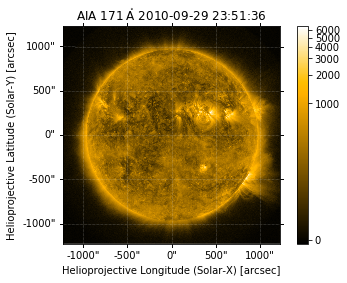

In [11]:
m.peek()

There are many different ways to construct a `Map`. For example, we can read the data in by hand and then pass the header and image data to `Map`.

In [12]:
_,(data,header) = sunpy.io.fits.read(files[0],)

In [13]:
_

HDPair(data=None, header=FileHeader([('SIMPLE', True), ('BITPIX', 16), ('NAXIS', 0), ('EXTEND', True), ('COMMENT', "FITS (Flexible Image Transport System) format is defined in 'Astronomy  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"), ('HISTORY', ''), ('KEYCOMMENTS', {'SIMPLE': 'file does conform to FITS standard', 'BITPIX': 'number of bits per data pixel', 'NAXIS': 'number of data axes', 'EXTEND': 'FITS dataset may contain extensions'}), ('WAVEUNIT', None)]))

In [14]:
data

array([[ 0,  1,  0, ..., -2,  1,  0],
       [ 1, -1,  1, ...,  0, -2, -1],
       [-1,  0, -1, ...,  1, -1, -2],
       ...,
       [ 1,  0,  1, ..., -1, -1,  0],
       [-1, -1, -1, ...,  0,  1, -2],
       [-1,  0, -1, ...,  1, -1, -2]], dtype=int16)

In [15]:
header

FileHeader([('XTENSION', 'IMAGE'),
            ('BITPIX', 16),
            ('NAXIS', 2),
            ('NAXIS1', 4096),
            ('NAXIS2', 4096),
            ('PCOUNT', 0),
            ('GCOUNT', 1),
            ('BLD_VERS', 'V5R12X'),
            ('LVL_NUM', 1.0),
            ('T_REC', '2010-09-29T23:51:37Z'),
            ('TRECSTEP', 1.0),
            ('TRECEPOC', '1977.01.01_00:00:00_TAI'),
            ('TRECROUN', 1),
            ('ORIGIN', 'SDO/JSOC-SDP'),
            ('DATE', '2012-10-11T14:03:06'),
            ('TELESCOP', 'SDO/AIA'),
            ('INSTRUME', 'AIA_3'),
            ('DATE-OBS', '2010-09-29T23:51:36.34'),
            ('T_OBS', '2010-09-29T23:51:37.34Z'),
            ('CAMERA', 3),
            ('IMG_TYPE', 'LIGHT'),
            ('EXPTIME', 2.000175),
            ('EXPSDEV', 0.000135),
            ('INT_TIME', 2.273438),
            ('WAVELNTH', 171),
            ('WAVEUNIT', 'angstrom'),
            ('WAVE_STR', '171_THIN'),
            ('FSN', 12898474),
      

In [16]:
m = Map(data,header)

In [17]:
m

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2010-09-29 23:51:36
Exposure Time:		 2.000175 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599489 0.599489] arcsec / pix
Reference Pixel:	 [2051.120117 2048.379883] pix
Reference Coord:	 [0. 0.] arcsec
array([[ 0,  1,  0, ..., -2,  1,  0],
       [ 1, -1,  1, ...,  0, -2, -1],
       [-1,  0, -1, ...,  1, -1, -2],
       ...,
       [ 1,  0,  1, ..., -1, -1,  0],
       [-1, -1, -1, ...,  0,  1, -2],
       [-1,  0, -1, ...,  1, -1, -2]], dtype=int16)

This is convenient when we want to modify the data or metadata in some way and then construct a new map from the modified data or metadata.

**NOTE:** When loading in or visualizing an image, `Map` is **not** manipulating the data, e.g. it is not being derotated, processed to level 1.5, reprojected, or being normalized in any way. These operations must be applied *explicitly*.

In [18]:
m.data

array([[ 0,  1,  0, ..., -2,  1,  0],
       [ 1, -1,  1, ...,  0, -2, -1],
       [-1,  0, -1, ...,  1, -1, -2],
       ...,
       [ 1,  0,  1, ..., -1, -1,  0],
       [-1, -1, -1, ...,  0,  1, -2],
       [-1,  0, -1, ...,  1, -1, -2]], dtype=int16)

In [21]:
m.data.shape

(4096, 4096)

In [19]:
m.data[2000,2000]

252

In [20]:
m.data[:,3000]

array([ 4,  8,  6, ...,  8,  5, 11], dtype=int16)

In [23]:
m.meta

MetaDict([('xtension', 'IMAGE'),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('pcount', 0),
          ('gcount', 1),
          ('bld_vers', 'V5R12X'),
          ('lvl_num', 1.0),
          ('t_rec', '2010-09-29T23:51:37Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2012-10-11T14:03:06'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_3'),
          ('date-obs', '2010-09-29T23:51:36.34'),
          ('t_obs', '2010-09-29T23:51:37.34Z'),
          ('camera', 3),
          ('img_type', 'LIGHT'),
          ('exptime', 2.000175),
          ('expsdev', 0.000135),
          ('int_time', 2.273438),
          ('wavelnth', 171),
          ('waveunit', 'angstrom'),
          ('wave_str', '171_THIN'),
          ('fsn', 12898474),
          ('fid', 0),
          ('quallev0', 0),
          ('q

However, we do not need to search through the many header keywords to get useful information about our image. The `Map` object exposes many of these as attributes which can be accessed via the `.` operator.

In [24]:
m.date

<Time object: scale='utc' format='isot' value=2010-09-29T23:51:36.340>

In [26]:
m.dimensions

PixelPair(x=<Quantity 4096. pix>, y=<Quantity 4096. pix>)

In [27]:
m.exposure_time

<Quantity 2.000175 s>

In [28]:
m.scale

SpatialPair(axis1=<Quantity 0.599489 arcsec / pix>, axis2=<Quantity 0.599489 arcsec / pix>)

In [29]:
m.wavelength

<Quantity 171. Angstrom>

**NOTE:** In a Jupyter notebook, if you type `m.` and then press the the tab key, you will be presented with a list of all the attributes and methods available for `Map`.

## Aside: Sequences of Multiple Images (in time, wavelength, etc.)

`Map` does support loading multiple images in a sequence. For example, to load the sequence of AIA images we queried above,

In [31]:
map_seq = Map(files, sequence=True)

In [32]:
map_seq

In [33]:
len(map_seq.maps)

4

In [34]:
map_seq.maps[2]

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2010-09-30 07:51:36
Exposure Time:		 1.999611 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.599489 0.599489] arcsec / pix
Reference Pixel:	 [2051.120117 2048.379883] pix
Reference Coord:	 [0. 0.] arcsec
array([[ 1,  2,  1, ...,  0, -1, -1],
       [-1,  1,  1, ..., -2, -1,  0],
       [ 0, -1,  1, ..., -2,  0, -1],
       ...,
       [-2,  0, -2, ...,  1, -2,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [-1, -2, -1, ...,  0,  0,  0]], dtype=int16)

In [35]:
map_seq.as_array().shape

(4096, 4096, 4)

However, `MapSequence` has seen little development in the recent years and its capabilities are fairly limited. This is partially because efforts around multi-dimensional data representation have been focused on the [NDCube](https://docs.sunpy.org/projects/ndcube/en/stable/) project, a SunPy-affiliated package.

## Aside: Units

In `sunpy`, all inputs and outputs that represent physical quantities must have units atteched to them, i.e. they must be represented as an `astropy.units.Quantity` object (data + unit).

The unit of these physical quantities can be accessed as,

In [36]:
m.wavelength.unit

Unit("Angstrom")

And the raw values can also be isolated,

In [37]:
m.wavelength.value

171.0

It is also simple to convert between different units

In [41]:
m.wavelength.to(u.nm)

<Quantity 17.1 nm>

In [42]:
m.wavelength.to('cm')

<Quantity 1.71e-06 cm>

You can do arithmetic between them as well

In [43]:
10 * u.m / (5 * u.s)

<Quantity 2. m / s>

In [44]:
1 * u.h + 2 * u.minute

<Quantity 1.03333333 h>

In [45]:
(1 * u.h + 2 * u.minute).to(u.s)

<Quantity 3720. s>

Attaching units to everything prevents you from making silly mistakes! (This should not work)

In [46]:
1 * u.erg + 34 * u.s

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

You can even construct quantities from "imperial" units

In [47]:
24 * u.imperial.inch / u.minute + 7 * u.imperial.furlong / u.day

<Quantity 62.5 inch / min>

All of this functionality extends to arrays as well. Any$^*$ operation you can do with a NumPy array, you can do with a `Quantity`.

$*$ Not every NumPy function will preserve the units on a quantity and some may complain about them. If that is the case, you can always get the raw values (with `.value`) and attach the units after returning the result.

In [48]:
v = np.random.rand(10) * u.cm / u.s
v

<Quantity [0.5932544 , 0.79654387, 0.48824233, 0.62326188, 0.14067687,
           0.35768199, 0.06517124, 0.89706558, 0.39348692, 0.79901709] cm / s>

In [49]:
v * u.Quantity(0.1, 's')

<Quantity [0.05932544, 0.07965439, 0.04882423, 0.06232619, 0.01406769,
           0.0357682 , 0.00651712, 0.08970656, 0.03934869, 0.07990171] cm>

## Image Manipulation

Thus far, we've fetched our data, loaded it into a `Map`, and looked at the various bits of metadata that `Map` exposes. Now, we want explore various ways in which we can manipulate our image data.

### Resampling

Choose a new resolution for the map

In [50]:
new_res = 30 * u.arcsec / u.pixel

Use the existing dimensions and the resolution, we can calculate the new dimensions of our resampled `Map`.

In [51]:
dim_x = m.dimensions.x * m.scale.axis1 / new_res
dim_y = m.dimensions.y * m.scale.axis2 / new_res
new_dimensions = u.Quantity([dim_x,dim_y])
new_dimensions

<Quantity [81.85023147, 81.85023147] pix>

In [52]:
m_resample = m.resample(new_dimensions)

And when we expect the metadata, we should find it has the appropriate resolution and dimensions

In [53]:
m_resample.scale

SpatialPair(axis1=<Quantity 30. arcsec / pix>, axis2=<Quantity 30. arcsec / pix>)

In [54]:
m_resample.dimensions

PixelPair(x=<Quantity 82. pix>, y=<Quantity 82. pix>)

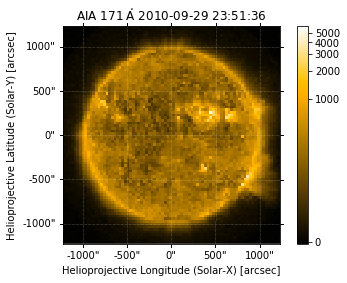

In [55]:
m_resample.peek()

### Rotating

We can also rotate our `Map` about the axis that points out of the page.

In [56]:
m_rot = m.rotate(angle=45*u.degree, use_scipy=True)

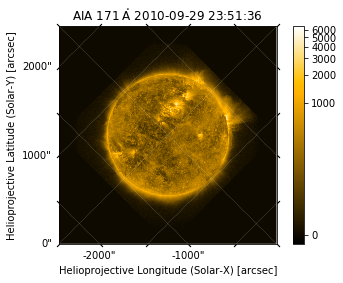

In [57]:
m_rot.peek()

This will come up again when we demonstrate image [registration](#Data-"Prep").

### Cropping

We can create cutouts from our images using the `.submap` method. `submap()` takes two arguments: the lower left corner and upper right corner of the bounding box that define the cutout.

In [58]:
m_sub = m.submap(
    SkyCoord(150*u.arcsec, 50*u.arcsec, frame=m.coordinate_frame),
    SkyCoord(550*u.arcsec, 450*u.arcsec, frame=m.coordinate_frame),
)

The locations of the bounding box corners must be expressed as `astropy.coordinates.SkyCoord` objects. A `SkyCoord` is essentially a coordinate-aware array that defines a location in that particularly coordinate system. Notice that we've said these coordinates are in the coordinate system of the image, in this case a helioprojective (HPC) coordinate system defined by the position of SDO at the time of the observation. A more extensive disucssion of coordinates in `sunpy` is given [below](#Coordinates).

When we check the dimensions of our cutout, we should find them be to consistent with our specified bounding box.

In [59]:
m_sub.dimensions

PixelPair(x=<Quantity 667. pix>, y=<Quantity 667. pix>)

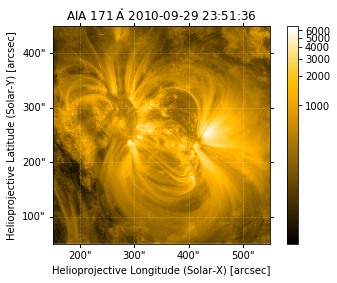

In [60]:
m_sub.peek()

### Differential Rotation

**WARNING! Running the code in this section on mybinder.org is likely to kill your whole notebook!**

In order to account for the rotation of the solar surface, we can warp our image such that a given physical location on the Sun corresponds to approximately to the same pixel location over a given time interval. This function also accounts for the latitudinal variation in the solar rotation rate. For example, to warp our first image forward in time such that it is approximately aligned with our last image that we queried and downloaded in the first step (observed approximately 8 h after the first image),

In [61]:
m_last = Map(files[-1])

In [62]:
m_diffrot = differential_rotate(m, observer=m_last.observer_coordinate)

Let's look at a zoomed in view of the derotated maps.

Text(0.5, 1.0, 'Map 1 derotated to Map 2')

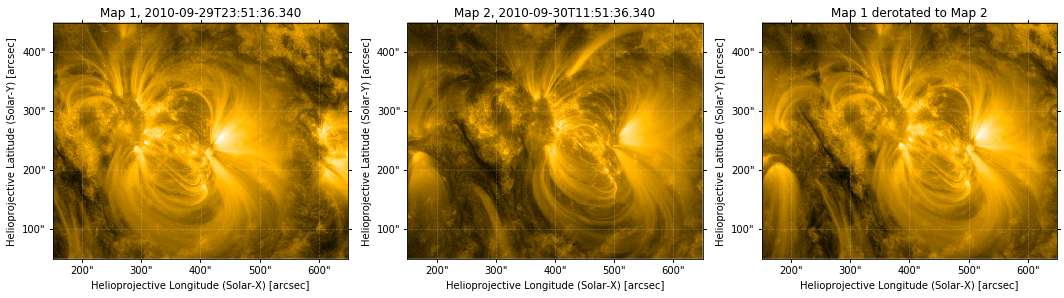

In [63]:
fig = plt.figure(figsize=(18,6))
_m_sub = m.submap(SkyCoord(150*u.arcsec, 50*u.arcsec, frame=m.coordinate_frame),
                  SkyCoord(650*u.arcsec, 450*u.arcsec, frame=m.coordinate_frame))
ax = fig.add_subplot(131,projection=_m_sub)
_m_sub.plot(axes=ax)
ax.set_title(f'Map 1, {_m_sub.date.isot}')
_m_sub = m_last.submap(SkyCoord(150*u.arcsec, 50*u.arcsec, frame=m_last.coordinate_frame),
                       SkyCoord(650*u.arcsec, 450*u.arcsec, frame=m_last.coordinate_frame))
ax = fig.add_subplot(132,projection=_m_sub)
_m_sub.plot(axes=ax)
ax.set_title(f'Map 2, {_m_sub.date.isot}')
_m_sub = m_diffrot.submap(SkyCoord(150*u.arcsec, 50*u.arcsec, frame=m_diffrot.coordinate_frame),
                          SkyCoord(650*u.arcsec, 450*u.arcsec, frame=m_diffrot.coordinate_frame))
ax = fig.add_subplot(133,projection=_m_sub)
_m_sub.plot(axes=ax)
ax.set_title(f'Map 1 derotated to Map 2')

**NOTE:** We are not applying this to our submaps as this functionality is currently broken for submaps in version 1.0.3. See [this issue on GitHub](https://github.com/sunpy/sunpy/issues/3323).

## Coordinates

In [64]:
m.coordinate_frame

<Helioprojective Frame (obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>)>

In [65]:
m.center

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (-1.27111229, 0.37132408)>

![coordinate frames](sunpy_frames.png)

In [66]:
m.center.transform_to('heliographic_carrington')

<SkyCoord (HeliographicCarrington: obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (41.27462156, 6.81082128, 6.96e+08)>

We can even represent the center coordinate in terms of the right ascension and declination.

In [67]:
m.center.transform_to('icrs')

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, m)
    (75.84079905, 23.36780268, 2.79666176e+08)>

The map also holds the coordinates of the bounding box that defines the 2D map.

In [68]:
m.bottom_left_coord

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (-1228.59536747, -1227.76041437)>

In [69]:
m.top_right_coord

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (1226.0532329, 1228.50311312)>

For several examples of the power of the coordinates stack, see the following examples:

* [Modeling Coronal Loops in 3D](advanced/projecting-coronal-loops.ipynb)
* [Plotting Fieldlines from a PFSS Extrapolation](advanced/pfss-fieldlines.ipynb)

Other coordinate examples external to this tutorial:

* [Overplotting HEK Features (from the sunpy example gallery)](http://docs.sunpy.org/en/stable/generated/gallery/plotting/overplot_hek_polygon.html#sphx-glr-generated-gallery-plotting-overplot-hek-polygon-py)
* [Overplotting AIA/EUVI Coordinates](https://github.com/sunpy/tutorial-notebooks/blob/master/2019_spd/sunpy-1.0-spd2019-coordinates.ipynb)

## Visualization

As we've shown above the `.peek` command provides an easy way to quickly visualize our map.

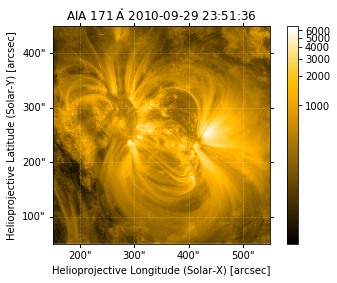

In [70]:
m_sub.peek()

Note that `.peek` gives us coordinate-aware axes as well as the standard AIA 171 colormap. This is all very nice, but does not give us much control over how the plot looks. This can be a problem, particularly when preparing figures for publication.

To customize the look of our plots, we can leverage all of the great features in [matplotlib](https://matplotlib.org/) to customize our plots. If we just plot our image using the standard [`imshow`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html) command in matplotlib,

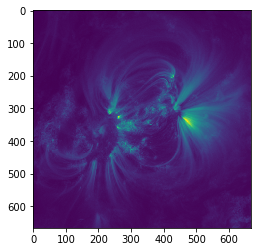

In [71]:
fig = plt.figure()
ax = fig.gca()
ax.imshow(m_sub.data)

Note that this gives us axes in pixel coordinates and image flipped upside down. Fortunately, `Map` provides the `plot` command,

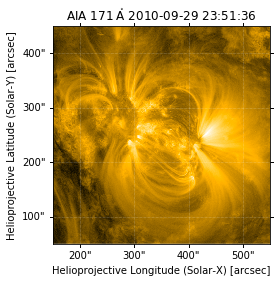

In [72]:
fig = plt.figure()
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax)

`plot` is just a wrapper around `imshow`, meaning it accepts all of the same arguments like the colormap and the limits and scale on the colorbar.

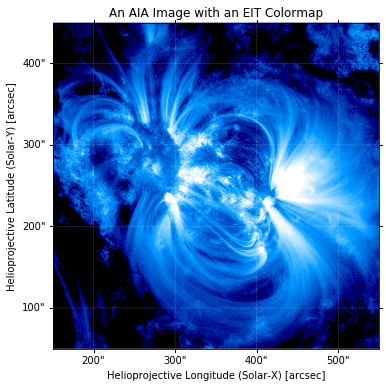

In [73]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax, cmap='sohoeit171', norm=ImageNormalize(vmin=2e2,vmax=3e3,stretch=LogStretch()))
ax.set_title('An AIA Image with an EIT Colormap');

All of the plotting capabilities provided by sunpy/astropy are built on top of matplotlib so any desired customizations can be done using matplotlib. The additional coordinate-aware axes support is provided by the astropy-affiliated [wcsaxes](https://wcsaxes.readthedocs.io/en/latest/) package. See the [notebook on advanced plotting](advanced/plotting.ipynb) for more examples of more fine-grained control over plot appearance.

The coordinate-aware capabilities allow us to easily overlay annotations or grids from other coordinate systems:

To draw a rectangle,

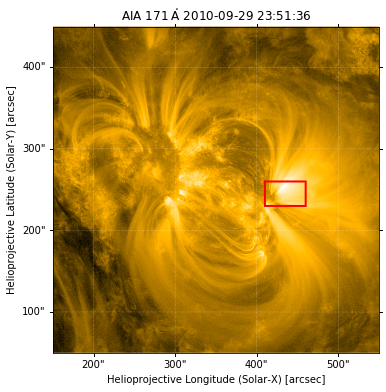

In [74]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax)
m_sub.draw_rectangle(SkyCoord(410*u.arcsec,230*u.arcsec,frame=m_sub.coordinate_frame),
                     50*u.arcsec, 30*u.arcsec, color='r', lw=2)

To overlay a heliographic stonyhurst (HGS) grid,

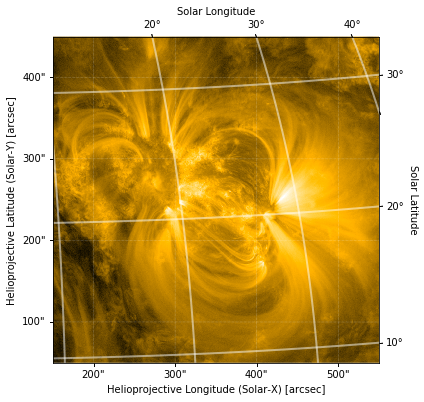

In [75]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax,title=False)
m_sub.draw_grid(axes=ax,grid_spacing=10*u.deg,lw=2)

Additionally, we can also plot points at arbitrary coordinates on our plot. Let's add a marker at the point where the intensity is greatest. First, find the pixel coordinate of the maximum value in the submap.

In [76]:
# the order is reversed because indices are ordered row,column
y,x = np.unravel_index(np.argmax(m_sub.data, axis=None), m_sub.data.shape)

Next, convert the pixel coordinates to a physical coordinate

In [77]:
coord_max = m_sub.pixel_to_world(x*u.pixel, y*u.pixel)

In [78]:
coord_max

<SkyCoord (Helioprojective: obstime=2010-09-29T23:51:36.340, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2010-09-29T23:51:36.340): (lon, lat, radius) in (deg, deg, m)
    (-0.00928619, 6.7887263, 1.49827386e+11)>): (Tx, Ty) in arcsec
    (432.0735467, 252.90186821)>

And plot the point on our AIA 171 map.

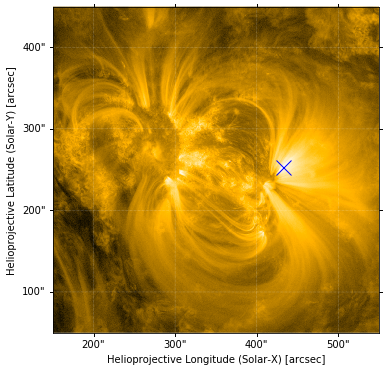

In [79]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax, title=False)
ax.plot_coord(coord_max, marker='x', markersize=15, color='b')

`plot_coord` can be used to plot much more interested features as well. See the [pfss fieldlines notebook](advanced/pfss-fieldlines.ipynb) for a more practical example.

As a last example, we can also add a mask to the map and it will automatically be applied when plotting. For example, to mask all pixels less than 300 DN,

In [80]:
mask = m_sub.data < 300  # This returns a boolean array
m_sub_mask = Map(m_sub.data, m_sub.meta, mask=mask)

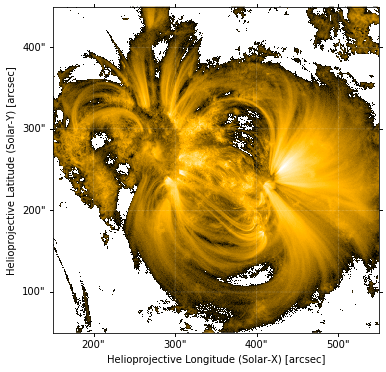

In [81]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection=m_sub_mask)
m_sub_mask.plot(axes=ax,title=False)

## `aiapy`: A Python Package for Analyzing AIA Data

In this section, we'll demo the capabilities of the recently-developed [aiapy](https://gitlab.com/LMSAL_HUB/aia_hub/aiapy) package. aiapy has been developed to be fully compatible with sunpy and the greater Python-in-Astronomy ecosystem and to extend the core capabilities of sunpy.

To start, let's query a recent 335 observation using `Fido`,

In [82]:
q = Fido.search(
    attrs.Time(TimeRange(astropy.time.Time('2017-09-10T16:00:00'), 1*u.minute)),
    attrs.Instrument('AIA'),
    attrs.Sample(2*u.minute),
    attrs.Wavelength(335*u.angstrom),
)

In [83]:
q

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2017-09-10 16:00:00,2017-09-10 16:00:01,SDO,AIA,FULLDISK,335.0 .. 335.0


In [84]:
files = Fido.fetch(q)

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.46s/file]


In [85]:
# In case the VSO is not cooperating, just grab them from local filesystem
# files = data/aia_lev1_335a_2017_09_10t16_00_00_63z_image_lev1.fits

In [86]:
m = Map(files)

There are several steps we might want to go through to "prep" our `Map` for analysis. Some of these may not necessarily be included in the standard `aia_prep.pro` in SSW.

### Fixing Headers

The first one of these is to fix the HGS observer keyword metadata. This is because the information in the FITS headers have recently been found to be innacurate.

`aiapy` provides a simple function for doing this which returns a new `Map` with the adjusted header keywords.

In [87]:
m_fixed = aiapy.calibrate.fix_observer_location(m)

In [88]:
print((m.meta['hgln_obs'] * u.deg).to(u.arcsec))
print((m.meta['hglt_obs'] * u.deg).to(u.arcsec))

0.0 arcsec
26060.4252 arcsec


In [89]:
print((m_fixed.meta['hgln_obs'] * u.deg).to(u.arcsec))
print((m_fixed.meta['hglt_obs'] * u.deg).to(u.arcsec))

30.657152725129414 arcsec
26066.76367091237 arcsec


### Update Pointing

Additionally, we might want to update the pointing information using the 3-hourly pointing tables from the JSOC.

`aiapy` provides a function that takes in a map, queries the JSOC for the relevant entry in the 3-hour pointing series, and updates the relevant entries in the metadata of the `Map`.

In [90]:
m_updated_pointing = aiapy.calibrate.update_pointing(m_fixed)

This information is of course also passed on to the various attributes

In [91]:
m_fixed.reference_pixel

PixelPair(x=<Quantity 2040.699951 pix>, y=<Quantity 2043.680054 pix>)

In [92]:
m_updated_pointing.reference_pixel

PixelPair(x=<Quantity 2040.177368 pix>, y=<Quantity 2042.221069 pix>)

### Image Registration

The last step in the usual "prep" process is image registration; that is

* aligning the y-axis of the image with solar north
* scaling the image to a resolution of 0.6 arcseconds per pixel, and
* translating the image such that center of the image is aligned with the center of the Sun.

This can all be done using the `register` function which is really just a wrapper around the `.rotate` method on `Map`.

In [93]:
m_level15 = aiapy.calibrate.register(m_updated_pointing, use_scipy=True)

**NOTE:** `.register` is nearly an identical copy of `sunpy.instr.aia.aiaprep`. Once `aiapy` development is more stable, users will be encouraged to use `register` over `aiaprep`. In the future, `aiaprep` will be removed from `sunpy`. See [this GitHub issue](https://github.com/sunpy/sunpy/issues/3282) for more details.

The differences are relatively small and difficult to identify visually. However, if we look at the rotation matrices before and after, we see that our registration operation has diagonalized the rotation matrix.

In [94]:
m_updated_pointing.rotation_matrix

array([[ 0.99999691,  0.0024861 ],
       [-0.0024861 ,  0.99999691]])

In [95]:
m_level15.rotation_matrix

array([[ 1.00000000e+00, -4.77522246e-20],
       [-4.77522246e-20,  1.00000000e+00]])

### Image Degradation

In addition to the more typical prep operations, `aiapy` also provides a function for calculating the time-dependent degradation for a given channel,

In [96]:
degradation = aiapy.calibrate.degradation_correction(m_level15.wavelength, m_level15.date)

To apply this correction to our `Map`,

In [97]:
m_corrected = Map(m_level15.data / degradation, m_level15.meta)

The above steps will be encapsulated in a single function and added to `aiapy` in the near future.

We can then compare the uncorrected and corrected images and look at their difference.

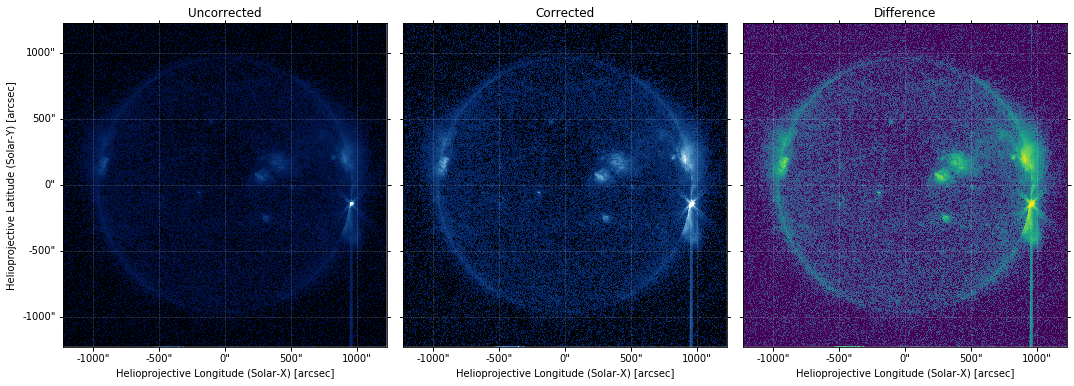

In [98]:
fig = plt.figure(figsize=(18,6))
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=SqrtStretch())
ax = fig.add_subplot(131, projection=m_level15)
m_level15.plot(axes=ax, norm=norm)
ax.set_title('Uncorrected')
ax = fig.add_subplot(132, projection=m_corrected)
m_corrected.plot(axes=ax, norm=norm)
ax.set_title('Corrected')
ax.coords[1].set_ticklabel_visible(False)
m_diff = Map(m_corrected.data - m_level15.data, m_corrected.meta,)
ax = fig.add_subplot(133, projection=m_diff)
m_diff.plot(axes=ax, vmin=0, vmax=500, cmap='viridis')
ax.set_title('Difference')
ax.coords[1].set_ticklabel_visible(False)
plt.subplots_adjust(wspace=0.05)

Using this function, we can also easily plot the degradation of the 335 channel as a function of the lifetime of the mission.

In [99]:
mission_time = astropy.time.Time('2010-06-01T00:00:00',scale='utc') + np.arange(0,9,0.01)*u.year

In [100]:
# Only read this table once
correction_table = aiapy.calibrate.util.get_correction_table()

In [101]:
degradation_335 = u.Quantity([aiapy.calibrate.degradation_correction(m_level15.wavelength,t,correction_table=correction_table).value
                              for t in mission_time])

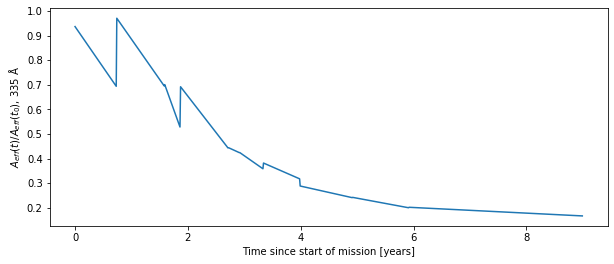

In [102]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
ax.plot((mission_time - mission_time[0]).to(u.year), degradation_335)
ax.set_xlabel('Time since start of mission [years]');
ax.set_ylabel(r'$A_{eff}(t)/A_{eff}(t_0)$, 335 $\mathrm{\AA}$');

### Wavelength Response Functions

Lastly, `aiapy` provides an interface to the wavelength response functions of the instrument via the `aiapy.response.Channel` object. To instantiate a `Channel`,

In [103]:
chan = aiapy.response.Channel(m_level15.wavelength)

`chan` now holds various properties of that particular channel, including basic metadata,

In [104]:
chan.channel

<Quantity 335. Angstrom>

In [105]:
chan.name

'335'

In [106]:
chan.plate_scale

<Quantity 8.46158039e-12 pix / sr>

As well as the various wavelength-dependent properties of the telescope.

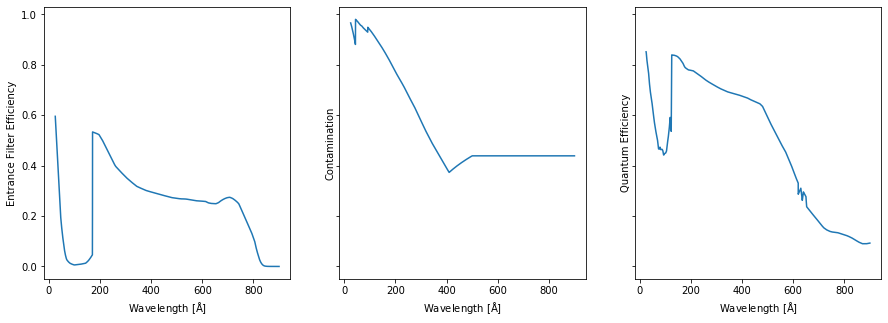

In [107]:
fig,axes = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
axes[0].plot(chan.wavelength, chan.entrance_filter_efficiency)
axes[1].plot(chan.wavelength, chan.contamination)
axes[2].plot(chan.wavelength, chan.quantum_efficiency)
axes[0].set_xlabel('Wavelength [$\mathrm{\AA}$]');
axes[0].set_ylabel('Entrance Filter Efficiency');
axes[1].set_xlabel('Wavelength [$\mathrm{\AA}$]');
axes[1].set_ylabel('Contamination');
axes[2].set_xlabel('Wavelength [$\mathrm{\AA}$]');
axes[2].set_ylabel('Quantum Efficiency');

Most importantly, `Channel` includes the ability to compute the wavelength response function.

In [108]:
response = chan.wavelength_response()

You can also choose to include the time-dependent degradation correction (as discussed [above](#Image-Degradation)) simply by passing in a particular observation time,

In [109]:
response_time = chan.wavelength_response(obstime=m_level15.date)

You can also include the so-called EVE correction (also time-dependent),

In [110]:
response_eve = chan.wavelength_response(obstime=m_level15.date,include_eve_correction=True)

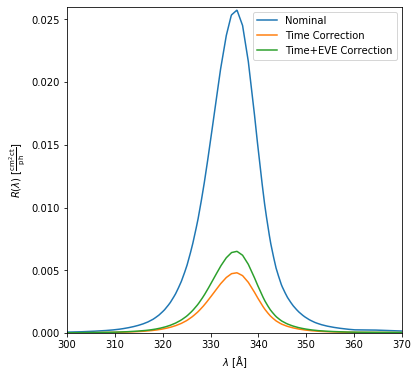

In [111]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot(chan.wavelength,response,label='Nominal')
ax.plot(chan.wavelength,response_time,label='Time Correction')
ax.plot(chan.wavelength,response_eve,label='Time+EVE Correction')
ax.set_xlim(300,370);
ax.set_ylim(0,0.026);
ax.legend();
ax.set_ylabel(f'$R(\lambda)$ [{response.unit.to_string("latex")}]');
ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]');

The temperature response functions are still a work in progress and are being tracked on [this issue](https://gitlab.com/LMSAL_HUB/aia_hub/aiapy/issues/23).

### PSF (coming soon!)